Predict whether a person will be diagnosed with diabetes or not

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import io
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('diabetes.csv')
data = df.copy()

In [3]:
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Checking for null values

In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

The data doesnt contain null values

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Inferences from the dataset

* The average BMI of the patients is 32 which is above the healthy weight range 18-25
* The maximum and minimum age among the patients are 81 and 21 respectively with the mean age at 33
* The average(120) glucose level of the patients falls within the healthy range (70 - 140)
* 75% of the patients have their glucose level at the max healthy range which implies most of the patients are more likely to be diagnosed with diabetes

so we check for zero values

In [7]:
cols = data.columns
for col in cols:
    print(col + ':', data[data[col]==0].shape[0])

Pregnancies: 111
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 500


* the output above shows the columns and their respective number of zero values

Here, the percentage of 0 values is calculated for each column to know the appropriate fill technique

In [8]:
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for i in zero_columns:
  percent = round(len(data[data[i]==0][i])/len(data[i])*100, 2)
  print(i +' -> '+ '{}%'.format(percent))

Glucose -> 0.65%
BloodPressure -> 4.56%
SkinThickness -> 29.56%
Insulin -> 48.7%
BMI -> 1.43%


Inferences

* The glucose, BloodPressure SkinThinkness and BMI have a very low amount of 0 values hence will be filled using the mean method
* The Insulin column has a high number of 0 values. It is medically not possible to have a 0 insulin value. This implies that an error must have occured when inputting values. Hence the entire column is dropped

Considering the fact we are trying to predict diabetes outcome, the glucose, bloodpressure, skinthickness and BMI cannot have a value of 0 (only if the patient is dead).

it only implies the values were not inputted so we fill it with the mean of the respective columns

In [9]:
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
for col in zero_columns:
  data[col] = data[col].replace(0, np.NaN) #replacing the 0 values with NaN
  mean = data[col].mean(skipna=True)
  data[col] = data[col].replace(np.NaN, mean) #replacing the NaN with the mean of the respective column
  
data = data.drop(columns='Insulin')

checking if the columns has been repaced with the mean

In [10]:
for col in zero_columns:
  print(col, data[data[col]==0].shape[0])

Glucose 0
BloodPressure 0
SkinThickness 0
BMI 0


average values by outcome

In [11]:
data.groupby('Outcome').mean().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,
0,3.30,110.71,70.94,27.77,30.89,0.43,31.19
1,4.87,142.17,75.15,31.74,35.38,0.55,37.07



# VISUALIZATION



Importing the visualization libraries

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df['BloodPressure'].unique()

array([ 72,  66,  64,  40,  74,  50,   0,  70,  96,  92,  80,  60,  84,
        30,  88,  90,  94,  76,  82,  75,  58,  78,  68, 110,  56,  62,
        85,  86,  48,  44,  65, 108,  55, 122,  54,  52,  98, 104,  95,
        46, 102, 100,  61,  24,  38, 106, 114], dtype=int64)

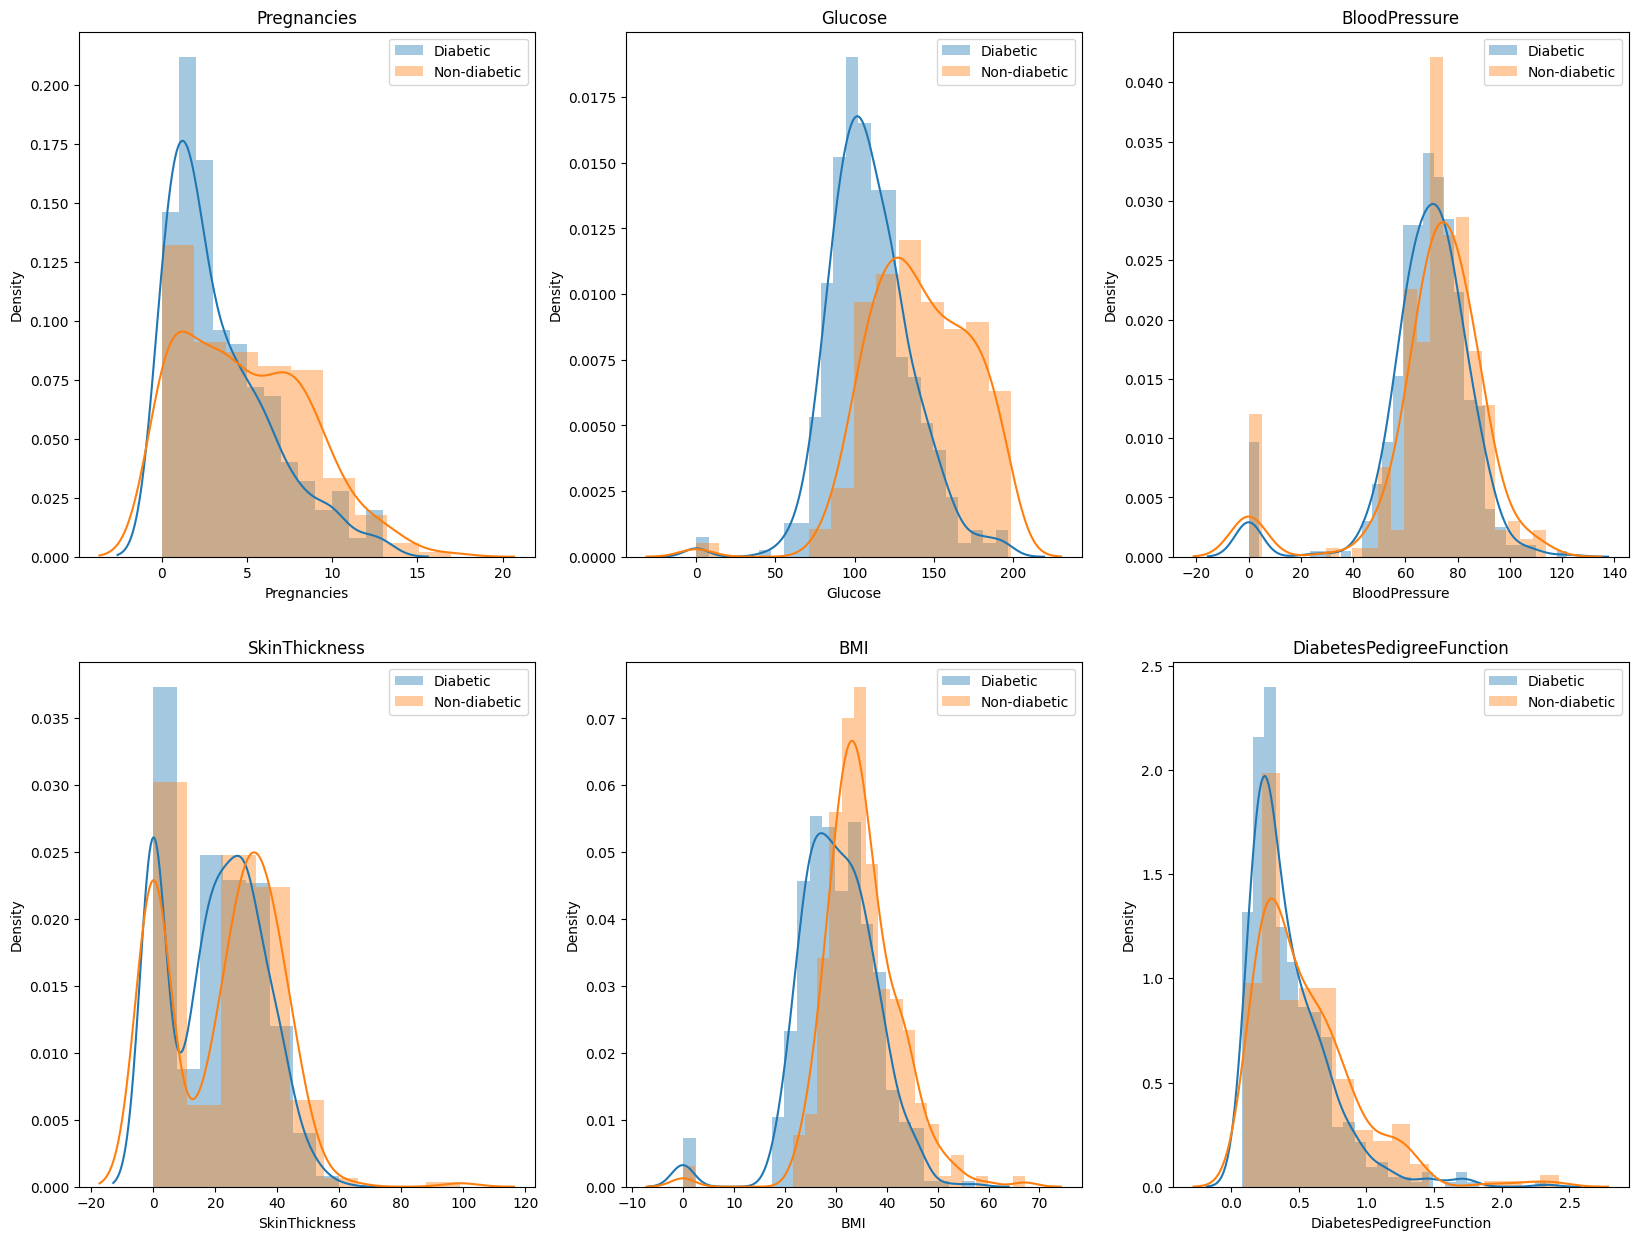

In [14]:

def plot(column):
    sns.distplot(df[df['Outcome'] == 0][column], label='Diabetic')
    sns.distplot(df[df['Outcome'] == 1][column], label='Non-diabetic')
    plt.title(column)
    plt.legend()
    

plt.figure(figsize=(20,15))
i=0
for j in data.columns[:6]:
    plt.subplot(2, 3, i+1)
    
    plot(j)
    
    i = i + 1
    


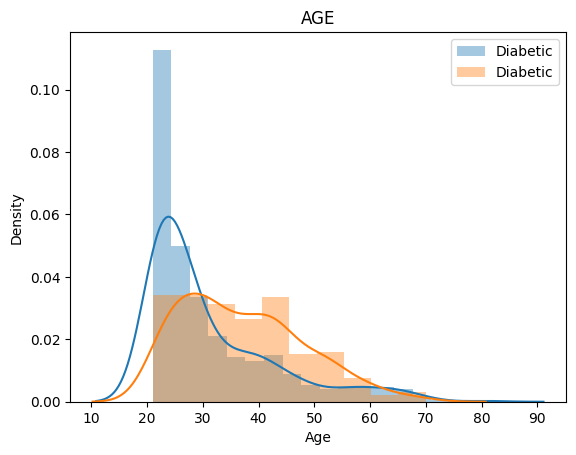

In [15]:
sns.distplot(df[df['Outcome'] == 0]['Age'], label='Diabetic')
sns.distplot(df[df['Outcome'] == 1]['Age'], label='Diabetic')
plt.title('AGE')
plt.legend()

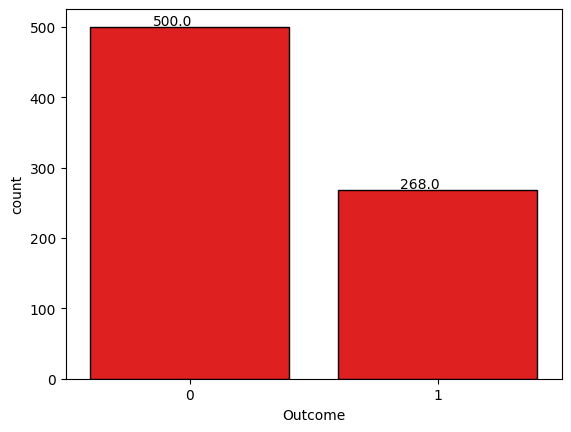

In [16]:
ax = sns.countplot(data['Outcome'], color=('red'), edgecolor='black')
for p in ax.patches:
  ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+2.5))

* Bcause we want to accurately predict both classes of the outcome, this dataset can be said to be an Imbalanced Dataset. 

The dataset will be balanced towards the end of the model obtain a more accurate model

<AxesSubplot:xlabel='Age', ylabel='Density'>

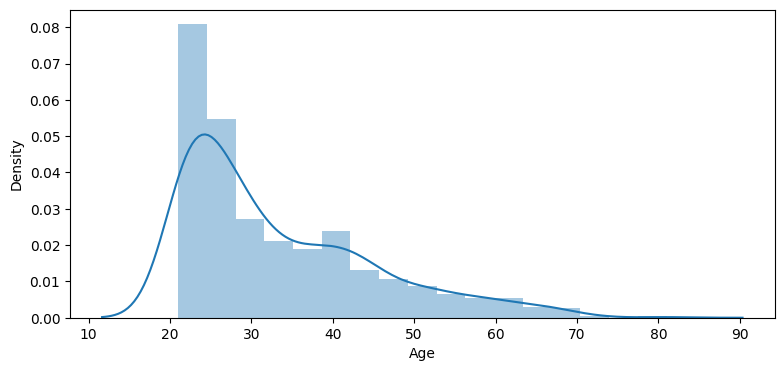

In [17]:
#Univariate analysis age.
f = plt.figure(figsize=(20,4))
f.add_subplot(1,2,1)
sns.distplot(data['Age'])

Text(0.5, 1.0, 'Boxplot of Age against outcome')

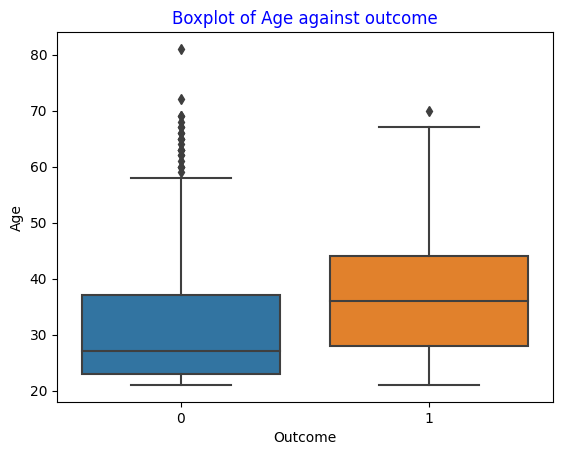

In [18]:
sns.boxplot(data= data, x='Outcome', y='Age')
plt.title('Boxplot of Age against outcome', color='blue')

* Majority of the patients falls between the ages of 20 and 40
* Patients between the ages of 30 and 45 are more likely to be diagnosed with diabetes

Text(0.5, 1.0, 'Boxplot of BMI against outcome')

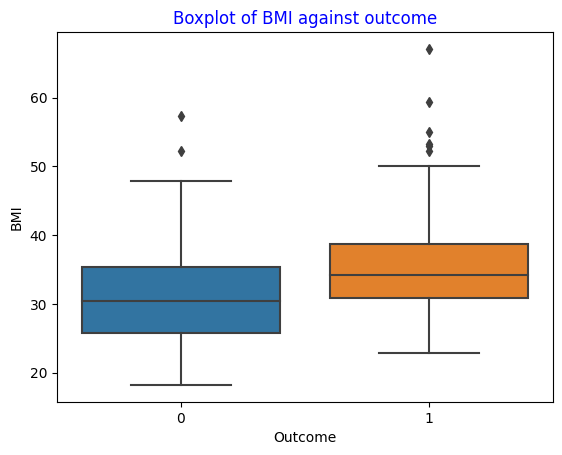

In [19]:
sns.boxplot(data= data, x='Outcome', y='BMI')
plt.title('Boxplot of BMI against outcome', color='blue')

Text(0.5, 1.0, 'Boxplot of BMI against outcome')

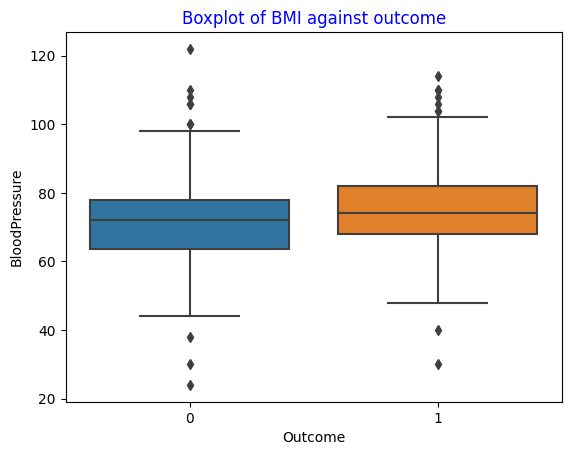

In [20]:
sns.boxplot(data= data, x='Outcome', y='BloodPressure')
plt.title('Boxplot of BMI against outcome', color='blue')

* Patients with higher BMI are most likely to be diagnosed with diabetes

Text(0.5, 1.0, 'Plot of BloodPressure against Insulin')

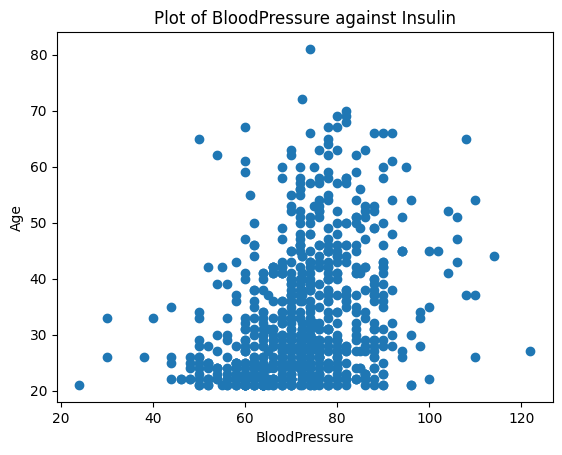

In [21]:
plt.scatter(data.BloodPressure, data.Age)
plt.xlabel('BloodPressure')
plt.ylabel('Age')
plt.title('Plot of BloodPressure against Insulin')

* Most Patients with BloodPressure between 40 and 100 are below 50 years

VISUALIZING THE COLUMS FOR OUTLIERS

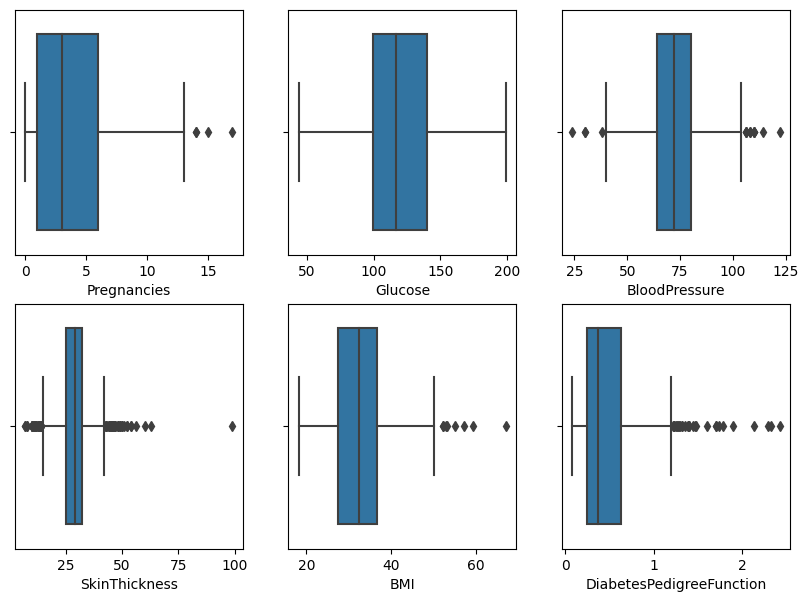

In [22]:
def plot(column):
    sns.boxplot(data[column])

plt.figure(figsize=(10, 7))
i=0
for j in data.columns[:6]:
    plt.subplot(2, 3, i+1)
    
    plot(j)
    
    i = i + 1

The plot above shows the datasets contains a lot of outliers; but these outliers wont be dealt with because they are actual inputs and they are examples of some extreme symptoms in patients

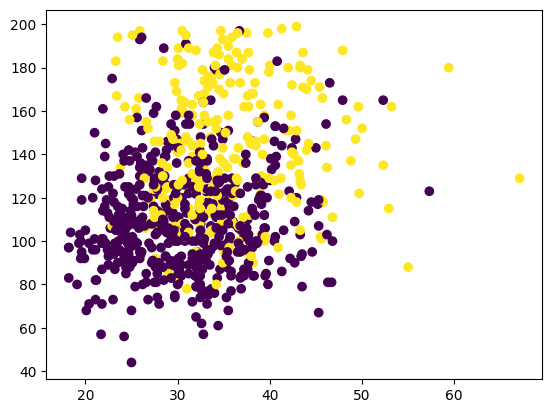

In [23]:
plt.scatter(data['BMI'], data['Glucose'], cmap='viridis', c=data['Outcome'])

# **DATA MODELLING**

Scalling, splitting and training the dataset

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SCALING

In [25]:
mnsc = MinMaxScaler() #Instantiation

data[data.columns[:-1]] = mnsc.fit_transform(data[data.columns[:-1]]) 
#Here, only the features is scaled 

In [26]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.240798,0.104294,0.253629,0.183333,1


A neural network will be built on the scaled dataset on another notebook, hence it is saved as a csv file

In [27]:
data.to_csv('scaled_data.csv')

SPLITTING AND TRAINING

In [28]:
x = data.iloc[:,0:-1]
y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (614, 7)
x_test:  (154, 7)
y_train:  (614,)
y_test:  (154,)


 **BASIC MODELING**

In [29]:
model = KNeighborsClassifier(n_neighbors=11, p=2, metric='euclidean', n_jobs=10)

model.fit(x_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=10, n_neighbors=11)

In [30]:
y_pred = model.predict(x_test)

**MODEL EVALUATION**

In [31]:
accuracy = round(accuracy_score(y_test, y_pred), 2)*100
print('Accuracy_Score: ', accuracy)

f1 = round(f1_score(y_test, y_pred), 4)*100
print('F1_Score: ', f1)

Accuracy_Score:  76.0
F1_Score:  66.06


Text(50.722222222222214, 0.5, 'True labels')

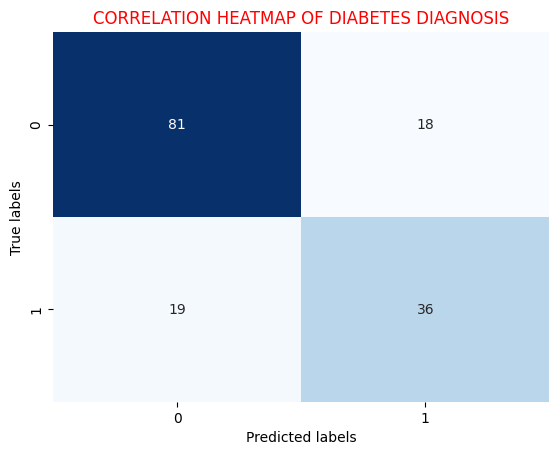

In [32]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix , annot=True, cbar=False, cmap='Blues')
plt.title('CORRELATION HEATMAP OF DIABETES DIAGNOSIS', color='red')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [33]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       100
           1       0.65      0.67      0.66        54

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



The model F1_score is quite low as a result of the dataset being slightly imbalanced

The imbalance dataset will be corrected using the RandomOverSampler technique

In [34]:
from imblearn.over_sampling import RandomOverSampler

Only the train dataset is over_sampled so that the model will not make prediction on fake data

In [35]:
sm = RandomOverSampler(random_state=42)
# Fit the model to generate the data.
oversampled_x_train, oversampled_y_train = sm.fit_resample(x_train, y_train)

In [36]:
 #checking if the dataset is balanced
 
print('oversampled_x_train: ', oversampled_x_train.shape) 
print('oversampled_y_train: ', oversampled_y_train.shape)
print(oversampled_y_train.value_counts())

oversampled_x_train:  (802, 7)
oversampled_y_train:  (802,)
0    401
1    401
Name: Outcome, dtype: int64


we can see that the dataset is balnced because the number of each unique value in the target column is now equal

### REMODELLING ON THE BALANCED DATASET

# KNN

In [37]:
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='euclidean')

knn.fit(oversampled_x_train, oversampled_y_train)
predictions = knn.predict(x_test)

acc= accuracy_score(y_test, predictions)
fscore = f1_score(y_test, predictions)

print('Accuracy: ', round(acc, 2)*100)
print('F1_Score: ', round(fscore, 2)*100)


Accuracy:  73.0
F1_Score:  68.0


storing the model in a pickle file

In [38]:
import pickle
pickle_file = open('knn.pkl', 'wb')
pickle.dump(knn, pickle_file)
pickle_file.close()

It is observed that smotening the dataset had little effect on the precision of the model


Hence the RandomForestClassifier is used bacause it is less sensitive to outliers

# RANDOM FOREST

In [39]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, n_estimators=120)
rfc.fit(oversampled_x_train, oversampled_y_train)
rfc_pred = rfc.predict(x_test)

rfc_accuracy = accuracy_score(y_test, rfc_pred)
print('Accuracy_Score: {}%'.format(round(rfc_accuracy,4)*100))
print('F1_Score: {}%'.format(round(f1_score(y_test, rfc_pred),4)*100))

Accuracy_Score: 77.27000000000001%
F1_Score: 72.0%


Saving the model in a pickle file for modelling

In [40]:
pickle_file = open('rfc.pkl', 'wb')
pickle.dump(rfc, pickle_file)
pickle_file.close()


# SUPPORT VECTOR

In [41]:
from sklearn.svm import SVC
svc = SVC(kernel='poly', C=2)
svc.fit(oversampled_x_train, oversampled_y_train)
svc_pred = svc.predict(x_test)

svc_accuracy = accuracy_score(y_test, svc_pred)
print('Accuracy_Score: {}%'.format(round(svc_accuracy ,4)*100))

print('F1_Score: {}%'.format(round(f1_score(y_test, svc_pred),4)*100))

Accuracy_Score: 77.92%
F1_Score: 71.19%


saving the model

In [42]:
file = open('svc.pkl', 'wb')
pickle.dump(svc, file)
file.close()

Noting the feature importance

<AxesSubplot:>

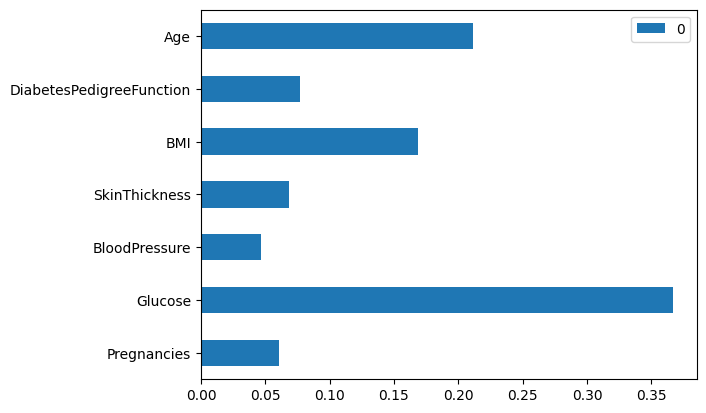

In [43]:
feature = rfc.feature_importances_
pd.DataFrame(feature, index = x.columns).plot(kind='barh')

This shows that glucose level is most important for detecting diabetes in patients